# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка данных

In [1]:
# Скачиваем нужные библиотеки
!pip install beautifulsoup4==4.9.3 matplotlib==3.3.4 nltk==3.6.1 numpy==1.20.1 pandas==1.2.4 plotly==5.4.0 psycopg2-binary==2.9.2 regex==2022.3.15 scikit-learn==1.6 scipy==1.8.0 seaborn==0.11.1 sqlalchemy==1.4.15 statsmodels==0.13.2 phik

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik;
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from numpy import sqrt
from numpy.random import RandomState

In [3]:
# Напишем функцию для считывания данных из csv файла и записывания в датафрейм
def df_read_csv(pth1, pth2):
    if os.path.exists(pth1):
        return pd.read_csv(pth1)
    elif os.path.exists(pth2):
        return pd.read_csv(pth2)
    else:
        print('Что-то пошло не так')

In [4]:
# Считываем данные из csv файла и записываем их в переменную df
df_geodata_0 = df_read_csv('/datasets/geo_data_0.csv', 'https://code.s3.yandex.net/datasets/geo_data_0.csv')
df_geodata_1 = df_read_csv('/datasets/geo_data_1.csv', 'https://code.s3.yandex.net/datasets/geo_data_1.csv')
df_geodata_2 = df_read_csv('/datasets/geo_data_2.csv', 'https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [5]:
# Создадим функцию, для отображения нужной информации о датафрейме
def df_info(df):
    display(df.head(10))
    display(df.info())
    display(df.describe())

In [6]:
# Отобразим информацию о df_geodata_0
df_info(df_geodata_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [7]:
# Отобразим информацию о df_geodata_1
df_info(df_geodata_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [8]:
# Отобразим информацию о df_geodata_2
df_info(df_geodata_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


После загрузки необходимых файлов, имеем 3 датафрейма и 5 уникальных столбцов с данными.

В датафрейме `df_geodata_0` мы сохранили данные с характеристиками скважин для региона 0.

В датафрейме `df_geodata_1` мы сохранили данные с характеристиками скважин для региона 1.

В датафрейме `df_geodata_2` мы сохранилии данные с характеристиками скважин для региона 2.

**Описание данных:**
1. id — уникальный идентификатор скважины;
2. f0, f1, f2 — три признака точек;
3. product — объём запасов в скважине (тыс. баррелей).

Необходимо будет заменить тип данных у некоторых столбцов.

##  Предобработка данных

### Выставление корректных типов данных

**Преобразуем тип данных float 64 в float 32 для экономии памяти в столбцах:**
- `f0`
- `f1`
- `f2`
- `product`

In [9]:
df_geodata_0['f0'] = df_geodata_0['f0'].astype('float32')
df_geodata_1['f0'] = df_geodata_1['f0'].astype('float32')
df_geodata_2['f0'] = df_geodata_2['f0'].astype('float32')

df_geodata_0['f1'] = df_geodata_0['f1'].astype('float32')
df_geodata_1['f1'] = df_geodata_1['f1'].astype('float32')
df_geodata_2['f1'] = df_geodata_2['f1'].astype('float32')

df_geodata_0['f2'] = df_geodata_0['f2'].astype('float32')
df_geodata_1['f2'] = df_geodata_1['f2'].astype('float32')
df_geodata_2['f2'] = df_geodata_2['f2'].astype('float32')

df_geodata_0['product'] = df_geodata_0['product'].astype('float32')
df_geodata_1['product'] = df_geodata_1['product'].astype('float32')
df_geodata_2['product'] = df_geodata_2['product'].astype('float32')

### Удаление пропусков

**Определим кол-во пропусков в каждом столбце**

In [10]:
df_geodata_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [11]:
df_geodata_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [12]:
df_geodata_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропуски не обнаружены.

### Обработка дубликатов

**Найдем неявные дубликаты**

In [13]:
# Найдем неявные дубликаты
print('Всего id в датафрейме df_geodata_0:', len(df_geodata_0['id']))
print('Из них уникальных id:', df_geodata_0['id'].nunique())
print('Доля неуникальных id:', (len(df_geodata_0['id']) - df_geodata_0['id'].nunique()) / len(df_geodata_0['id']) * 100, '%')
print('')
print('Всего id в датафрейме df_geodata_1:', len(df_geodata_1['id']))
print('Из них уникальных id:', df_geodata_1['id'].nunique())
print('Доля неуникальных id:', (len(df_geodata_1['id']) - df_geodata_1['id'].nunique()) / len(df_geodata_1['id']) * 100, '%')
print('')
print('Всего id в датафрейме df_geodata_2:', len(df_geodata_2['id']))
print('Из них уникальных id:', df_geodata_2['id'].nunique())
print('Доля неуникальных id:', (len(df_geodata_2['id']) - df_geodata_2['id'].nunique()) / len(df_geodata_2['id']) * 100, '%')

Всего id в датафрейме df_geodata_0: 100000
Из них уникальных id: 99990
Доля неуникальных id: 0.01 %

Всего id в датафрейме df_geodata_1: 100000
Из них уникальных id: 99996
Доля неуникальных id: 0.004 %

Всего id в датафрейме df_geodata_2: 100000
Из них уникальных id: 99996
Доля неуникальных id: 0.004 %


Доля неуникальных id во всех трех датафреймах меньше 1%, следовательно эти строки можно спокойно удалить

In [14]:
# Удалим неявные дубликаты
df_geodata_0['id'] = df_geodata_0['id'].drop_duplicates()
df_geodata_0 = df_geodata_0.dropna()

df_geodata_1['id'] = df_geodata_1['id'].drop_duplicates()
df_geodata_1 = df_geodata_1.dropna()

df_geodata_2['id'] = df_geodata_2['id'].drop_duplicates()
df_geodata_2 = df_geodata_2.dropna()

Неявные дубликаты устранены

**Найдем явные дубликаты**

In [15]:
# Найдем явные дубликаты
print(df_geodata_0.duplicated().sum())
print(df_geodata_1.duplicated().sum())
print(df_geodata_2.duplicated().sum())

0
0
0


Явные дубликаты не найдены

На этапе предобработки данных, нам удалось:
1. Проверить данные на наличие пропусков
2. Выставить корректные типы данных для экономии памяти
3. Обработать и избавиться от дубликатов

## Исследовательский анализ данных

In [16]:
# Создадим функцию для отображения количественных признаков
def quant_feat(df, col, title, xlabel, ylabel):
    # Отобразим данные в столбце col
    display(df[col].describe())
    
    # Отобразим гистограмму, построенную для столбца col
    plt.figure(figsize=(15,8))
    plt.title(title)
    sns.histplot(df[col]).set(xlabel=xlabel, ylabel=ylabel);
    
    # Отобразим ящик с усами, построенный для столбца col
    plt.figure(figsize=(15,8))
    plt.title(title)
    sns.boxplot(df[col]).set(ylabel=xlabel);

### Изучим и опишем данные из таблицы df_geodata_0

In [17]:
# Отобразим первые 10 строк в таблице df_geodata_0
df_geodata_0.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497822,1.221170,105.280060
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265648
3,iJLyR,-0.032172,0.139033,2.978566,168.620773
4,Xdl7t,1.988431,0.155413,4.751769,154.036652
5,wX4Hy,0.969570,0.489775,-0.735383,64.741539
6,tL6pL,0.645075,0.530656,1.780266,49.055286
7,BYPU6,-0.400648,0.808337,-5.624670,72.943291
8,j9Oui,0.643105,-0.551583,2.372141,113.356163
9,OLuZU,2.173381,0.563698,9.441853,127.910942


**Изучим столбец `f0`**

count    99990.000000
mean         0.500454
std          0.871844
min         -1.408605
25%         -0.072572
50%          0.502405
75%          1.073626
max          2.362331
Name: f0, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


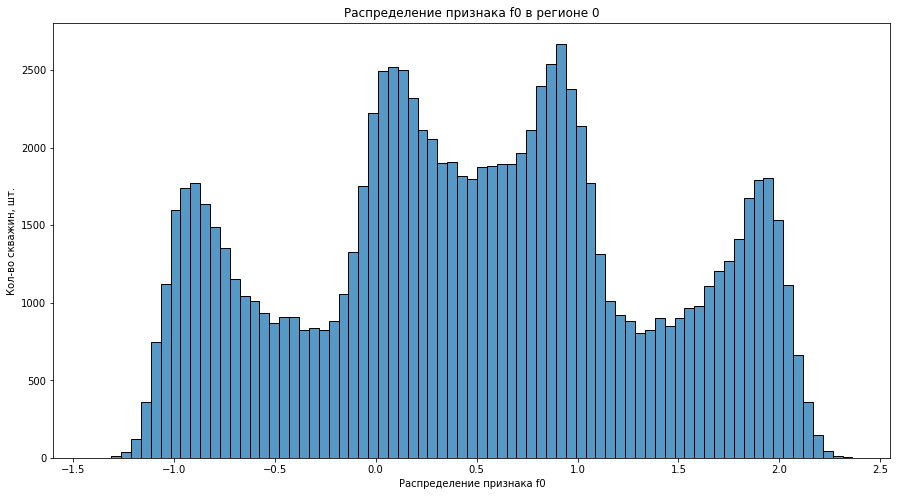

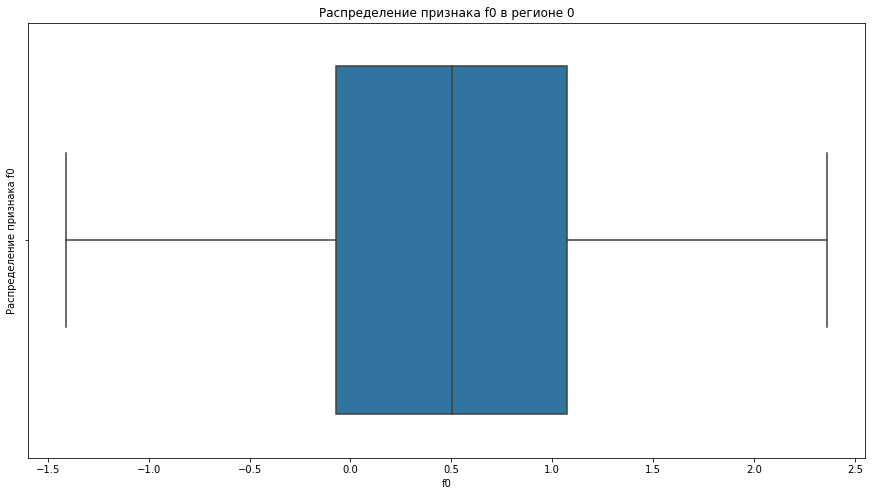

In [18]:
# Отобразим данные в столбце f0
quant_feat(df_geodata_0, 'f0', 'Распределение признака f0 в регионе 0', 'Распределение признака f0', 'Кол-во скважин, шт.')

**Изучим столбец `f1`**

count    99990.000000
mean         0.250141
std          0.504430
min         -0.848219
25%         -0.200877
50%          0.250252
75%          0.700640
max          1.343769
Name: f1, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


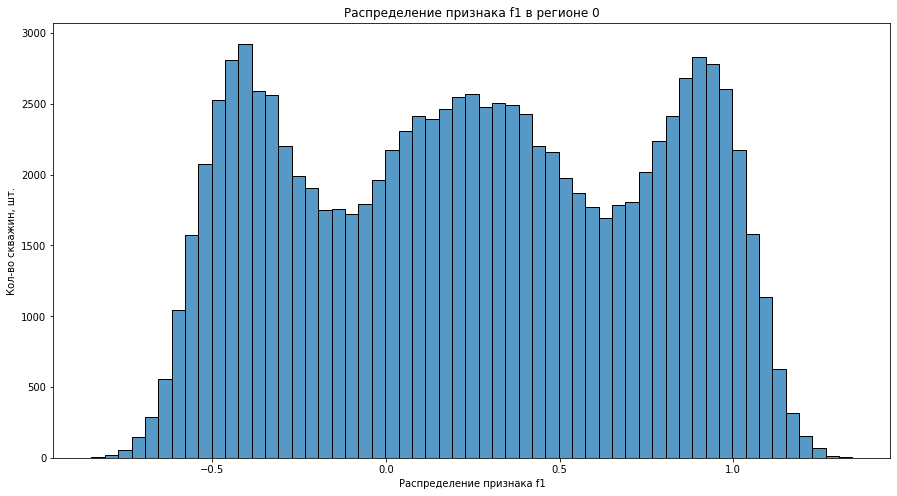

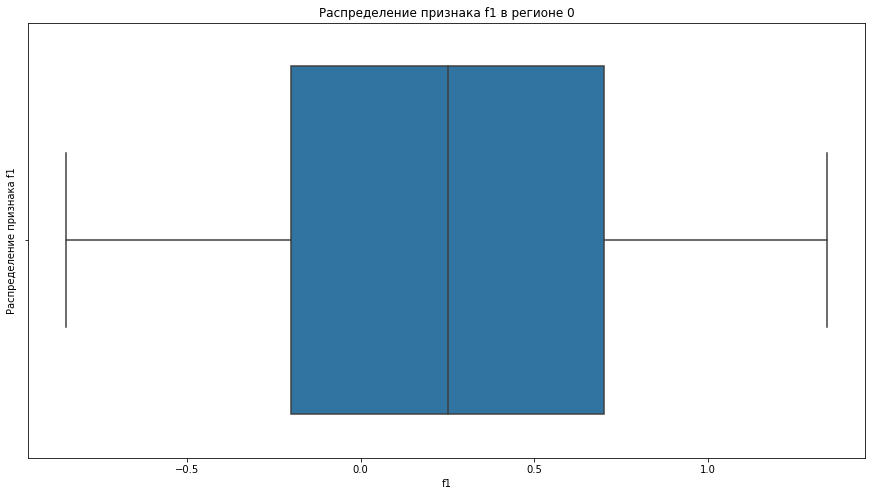

In [19]:
# Отобразим данные в столбце f1
quant_feat(df_geodata_0, 'f1', 'Распределение признака f1 в регионе 0', 'Распределение признака f1', 'Кол-во скважин, шт.')

**Изучим столбец `f2`**

count    99990.000000
mean         2.502629
std          3.248149
min        -12.088328
25%          0.287784
50%          2.515969
75%          4.715035
max         16.003790
Name: f2, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


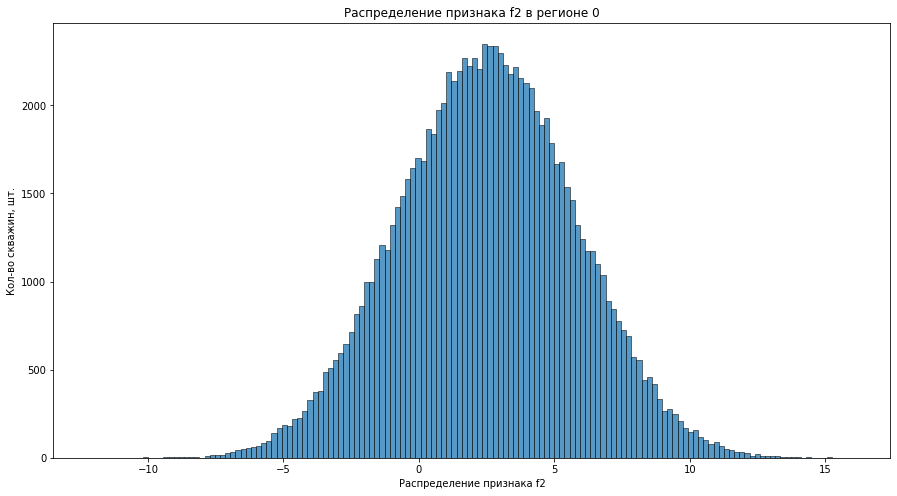

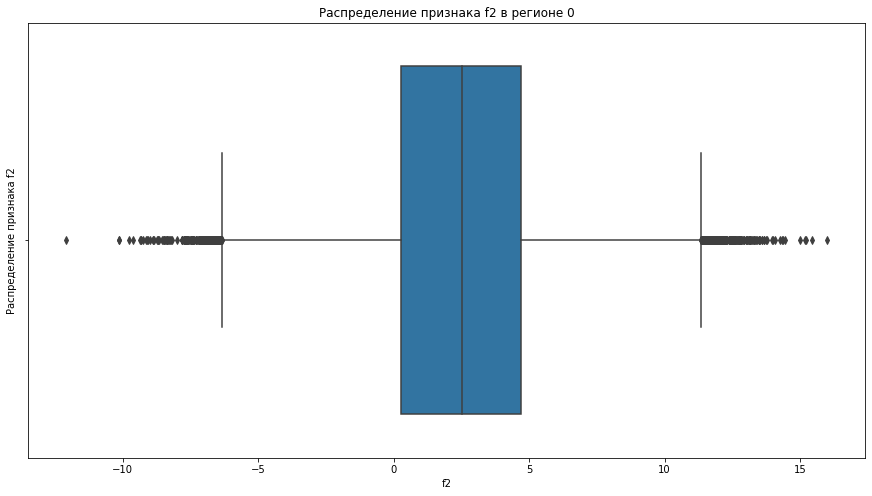

In [20]:
# Отобразим данные в столбце f2
quant_feat(df_geodata_0, 'f2', 'Распределение признака f2 в регионе 0', 'Распределение признака f2', 'Кол-во скважин, шт.')

**Изучим столбец `product`**

count    99990.000000
mean        92.499680
std         44.288303
min          0.000000
25%         56.497068
50%         91.847927
75%        128.563694
max        185.364349
Name: product, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


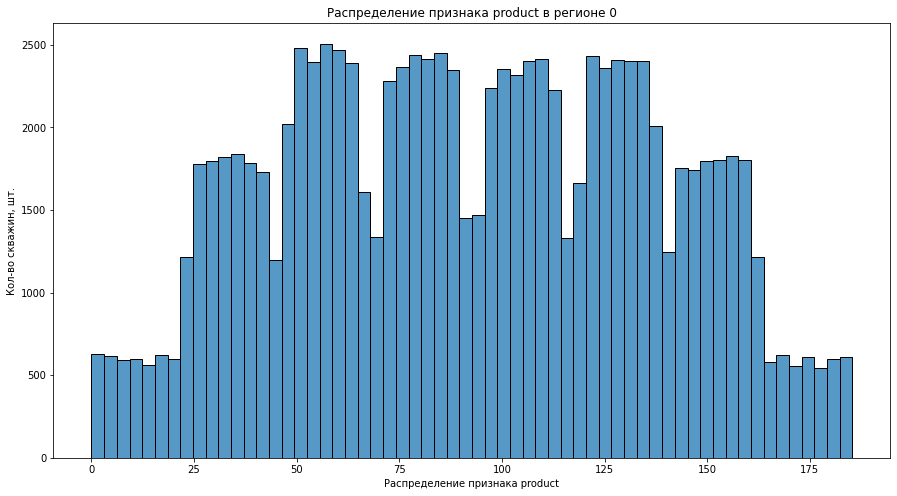

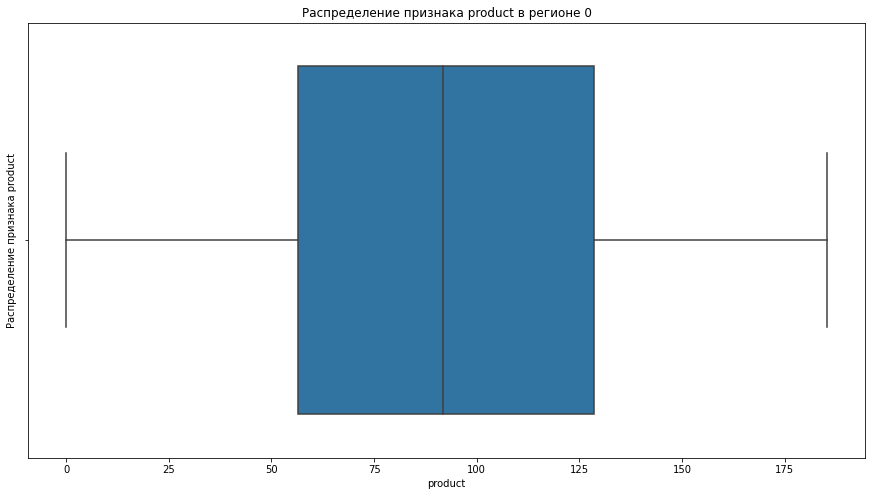

In [21]:
# Отобразим данные в столбце product
quant_feat(df_geodata_0, 'product', 'Распределение признака product в регионе 0', 'Распределение признака product', 'Кол-во скважин, шт.')

### Изучим и опишем данные из таблицы df_geodata_1

In [22]:
# Отобразим первые 10 строк в таблице df_geodata_1
df_geodata_1.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953260
2,vyE1P,6.263187,-5.948386,5.001160,134.766312
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945404
4,AHL4O,12.702195,-8.147433,5.004363,134.766312
5,HHckp,-3.327590,-2.205276,3.003647,84.038887
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992149
7,muH9x,4.234715,-0.001354,2.004588,53.906521
8,YiRkx,13.355129,-0.332068,4.998647,134.766312
9,jG6Gi,1.069227,-11.025667,4.997844,137.945404


**Изучим столбец `f0`**

count    99996.000000
mean         1.141209
std          8.965815
min        -31.609575
25%         -6.298551
50%          1.153055
75%          8.620963
max         29.421755
Name: f0, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


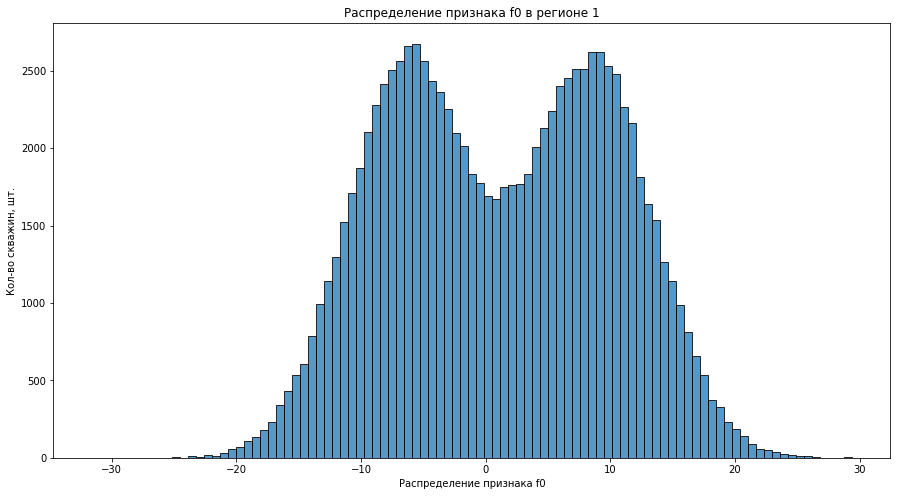

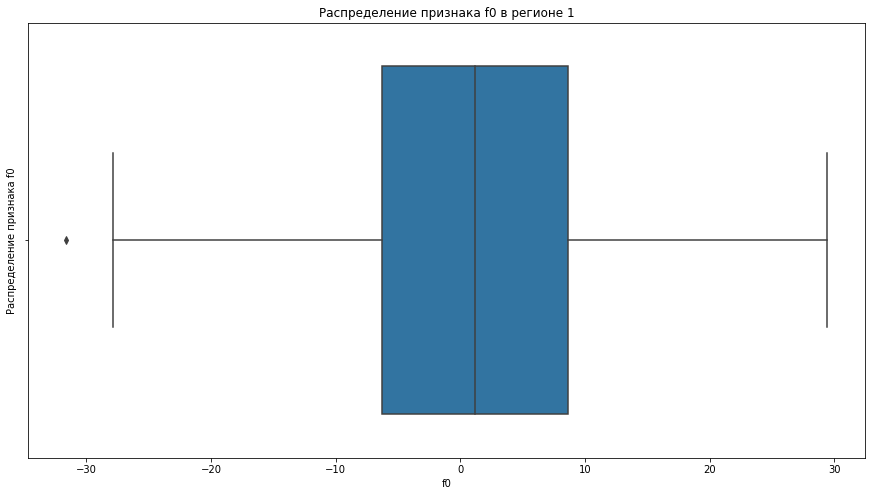

In [23]:
# Отобразим данные в столбце f0
quant_feat(df_geodata_1, 'f0', 'Распределение признака f0 в регионе 1', 'Распределение признака f0', 'Кол-во скважин, шт.')

**Изучим столбец `f1`**

count    99996.000000
mean        -4.796608
std          5.119905
min        -26.358599
25%         -8.267985
50%         -4.813172
75%         -1.332816
max         18.734062
Name: f1, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


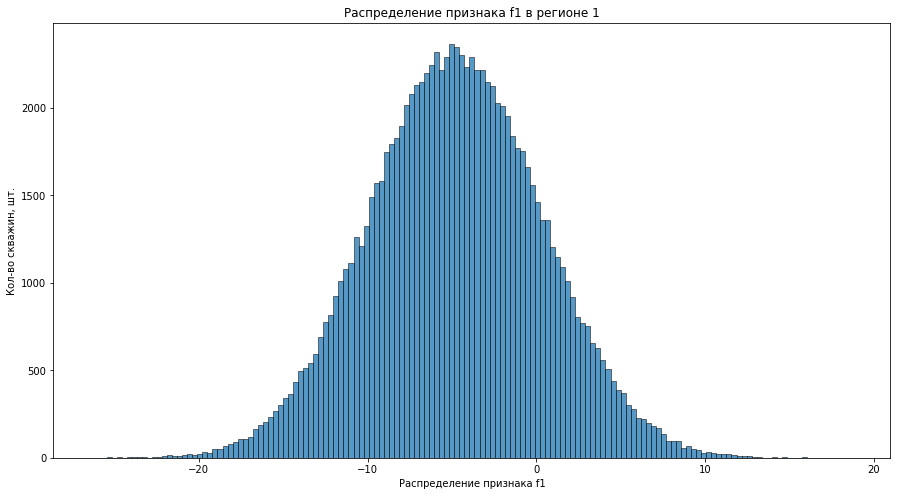

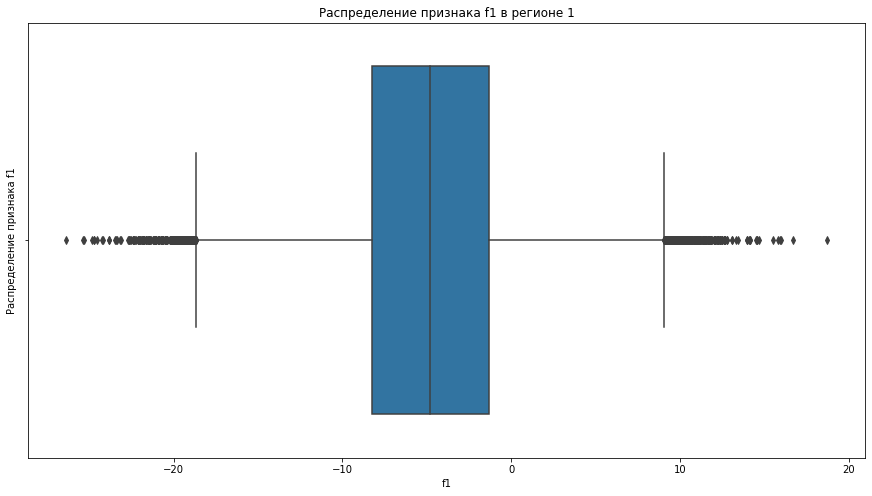

In [24]:
# Отобразим данные в столбце f1
quant_feat(df_geodata_1, 'f1', 'Распределение признака f1 в регионе 1', 'Распределение признака f1', 'Кол-во скважин, шт.')

**Изучим столбец `f2`**

count    99996.000000
mean         2.494501
std          1.703579
min         -0.018144
25%          1.000021
50%          2.011475
75%          3.999904
max          5.019721
Name: f2, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


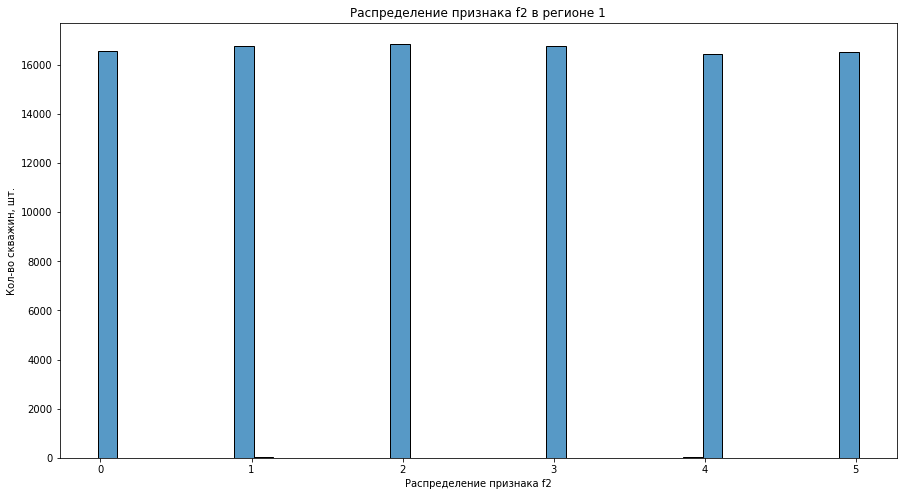

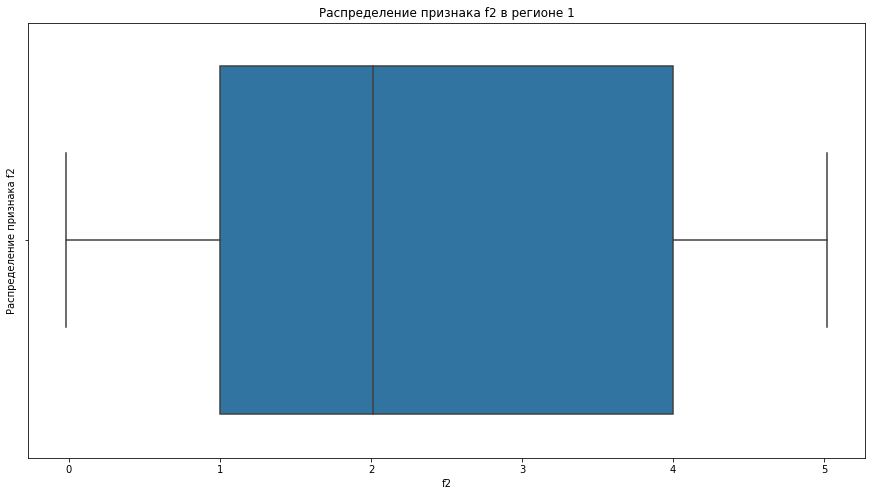

In [25]:
# Отобразим данные в столбце f2
quant_feat(df_geodata_1, 'f2', 'Распределение признака f2 в регионе 1', 'Распределение признака f2', 'Кол-во скважин, шт.')

**Изучим столбец `product`**

count    99996.000000
mean        68.823921
std         45.944664
min          0.000000
25%         26.953260
50%         57.085625
75%        107.813042
max        137.945404
Name: product, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


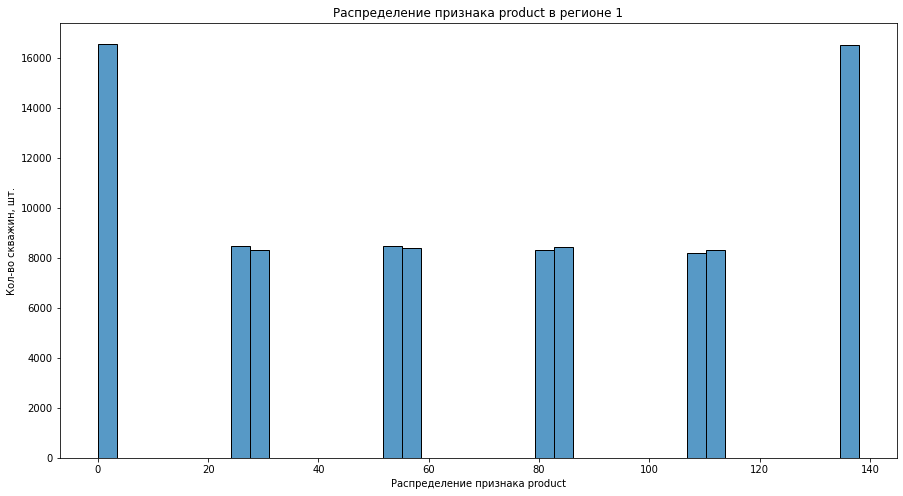

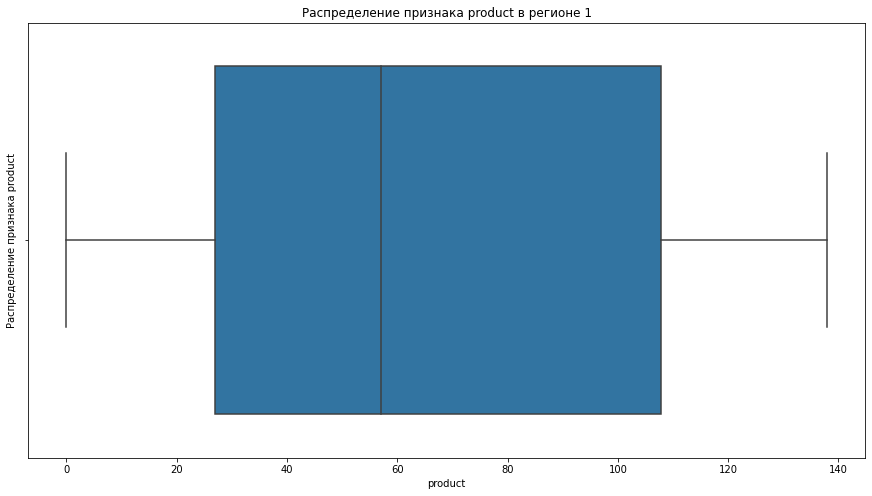

In [26]:
# Отобразим данные в столбце product
quant_feat(df_geodata_1, 'product', 'Распределение признака product в регионе 1', 'Распределение признака product', 'Кол-во скважин, шт.')

### Изучим и опишем данные из таблицы df_geodata_2

In [27]:
# Отобразим первые 10 строк в таблице df_geodata_2
df_geodata_2.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530186,56.069698
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572845
4,WPMUX,-0.515993,1.716266,5.899012,149.600739
5,LzZXx,-0.758092,0.710691,2.585887,90.222466
6,WBHRv,-0.574891,0.317727,1.773745,45.641479
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480637
8,ybmQ5,1.776291,-0.279356,3.004157,106.616829
9,OilcN,-1.214453,-0.439314,5.922514,52.954533


**Изучим столбец `f0`**

count    99996.000000
mean         0.002002
std          1.732052
min         -8.760004
25%         -1.162328
50%          0.009424
75%          1.158477
max          7.238263
Name: f0, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


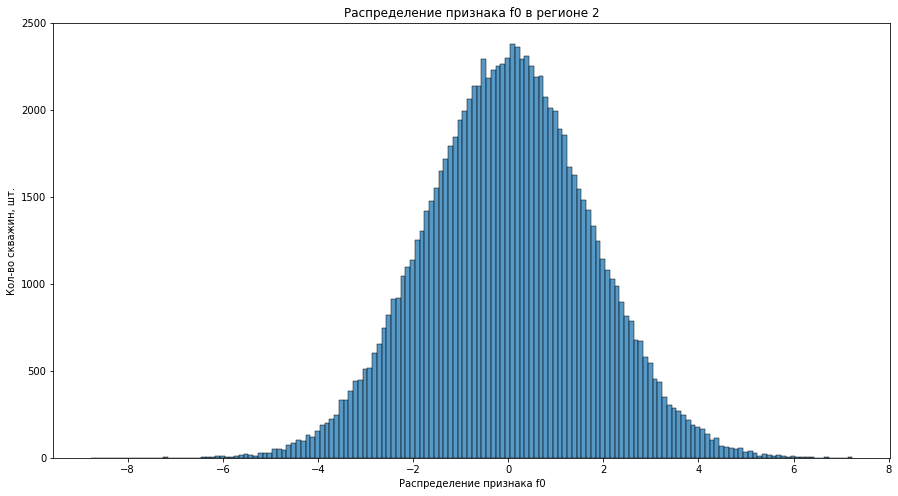

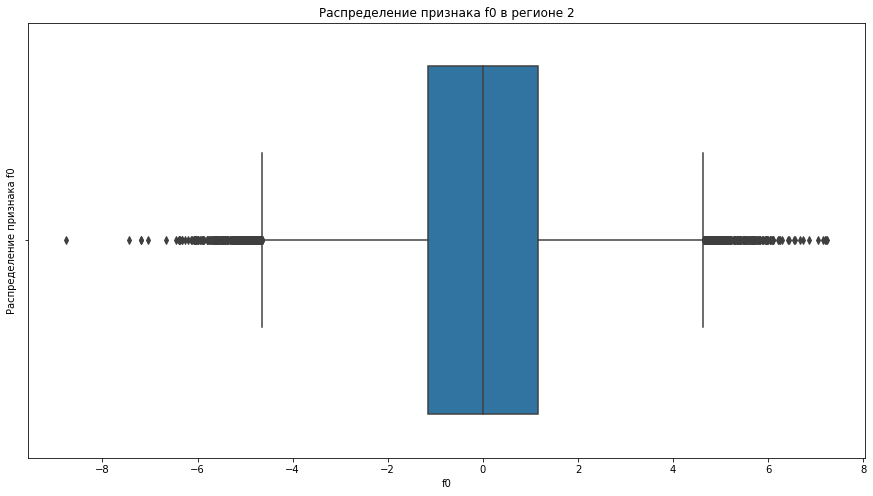

In [28]:
# Отобразим данные в столбце f0
quant_feat(df_geodata_2, 'f0', 'Распределение признака f0 в регионе 2', 'Распределение признака f0', 'Кол-во скважин, шт.')

**Изучим столбец `f1`**

count    99996.000000
mean        -0.002159
std          1.730397
min         -7.084020
25%         -1.174841
50%         -0.009661
75%          1.163523
max          7.844801
Name: f1, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


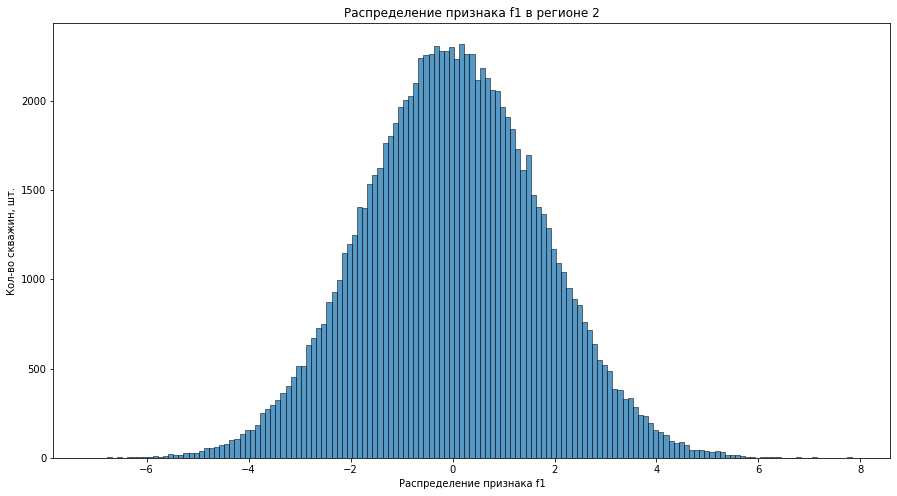

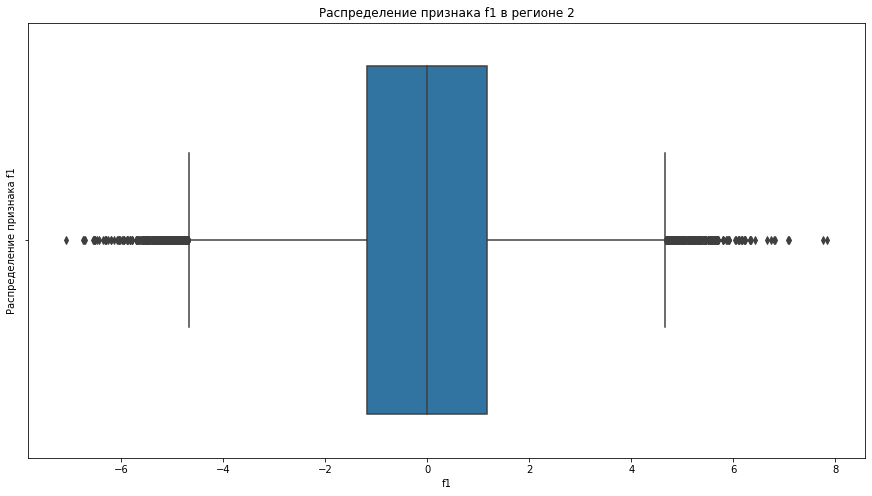

In [29]:
# Отобразим данные в столбце f1
quant_feat(df_geodata_2, 'f1', 'Распределение признака f1 в регионе 2', 'Распределение признака f1', 'Кол-во скважин, шт.')

**Изучим столбец `f2`**

count    99996.000000
mean         2.495084
std          3.473482
min        -11.970335
25%          0.130269
50%          2.484236
75%          4.858720
max         16.739403
Name: f2, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


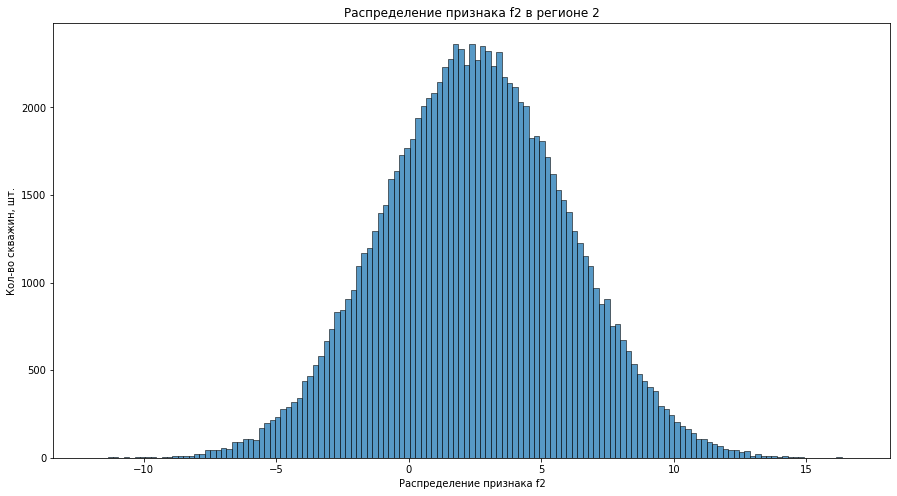

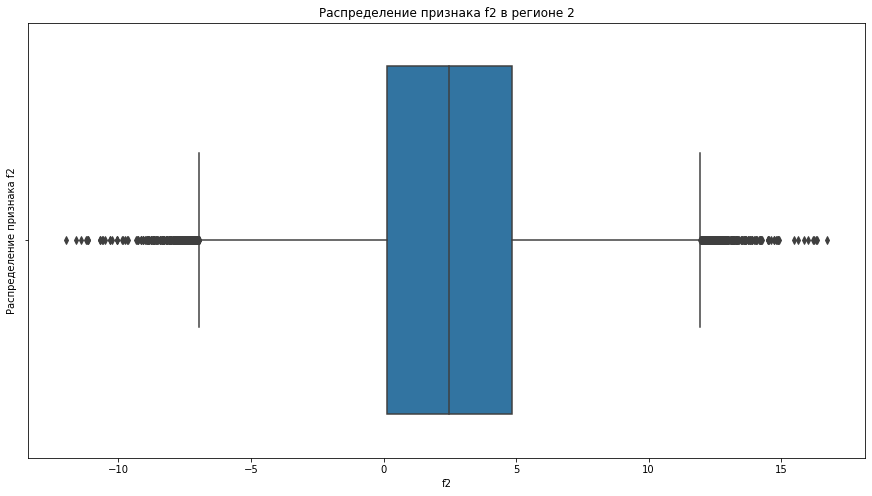

In [30]:
# Отобразим данные в столбце f2
quant_feat(df_geodata_2, 'f2', 'Распределение признака f2 в регионе 2', 'Распределение признака f2', 'Кол-во скважин, шт.')

**Изучим столбец `product`**

count    99996.000000
mean        94.998337
std         44.749573
min          0.000000
25%         59.450027
50%         94.925026
75%        130.586819
max        190.029831
Name: product, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


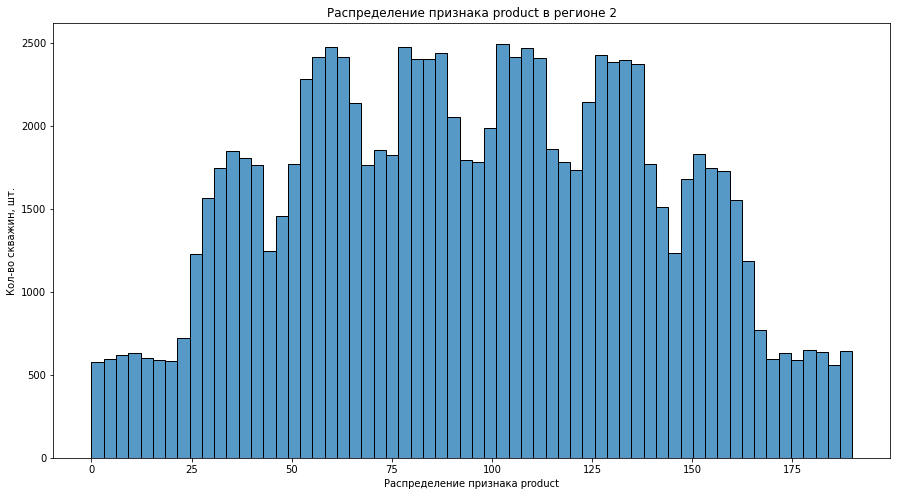

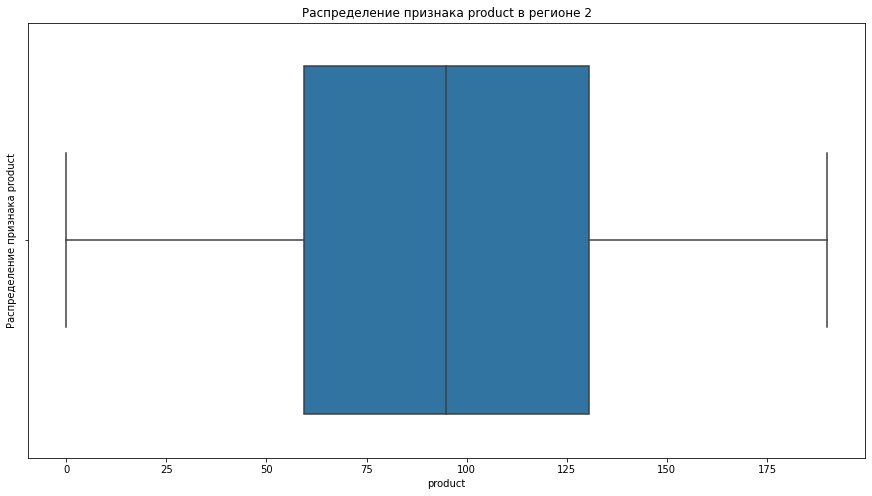

In [31]:
# Отобразим данные в столбце f2
quant_feat(df_geodata_2, 'product', 'Распределение признака product в регионе 2', 'Распределение признака product', 'Кол-во скважин, шт.')

На этапе исследовательского анализа данных, нам удалось:
1. Изучили и описали данные из таблицы df_geodata_0


2. Изучили и описали данные из таблицы df_geodata_1


3. Изучили и описали данные из таблицы df_geodata_2


По полученым данным, можно сказать:
- медианный объем запасов скважин в регионе 0 - 91 тыс. баррелей
- медианный объем запасов скважин в регионе 1 - 57 тыс. баррелей
- медианный объем запасов скважин в регионе 1 - 94 тыс. баррелей

##  Корреляционный анализ

**Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками**

In [32]:
# Превратим столбец 'id' в индекс
df_geodata_0 = df_geodata_0.set_index('id')
df_geodata_1 = df_geodata_1.set_index('id')
df_geodata_2 = df_geodata_2.set_index('id')

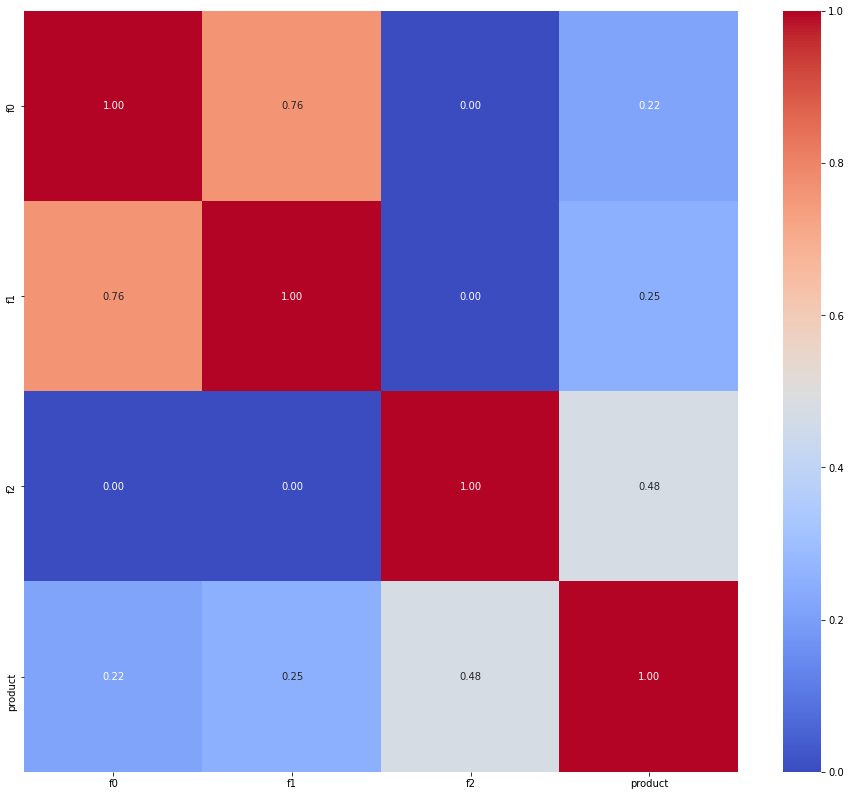

In [33]:
# Матрица корреляций для df_geodata_0
plt.figure(figsize=(16, 14))
sns.heatmap(df_geodata_0.phik_matrix(interval_cols = ['f0', 'f1', 'f2', 'product']), annot=True,  cmap='coolwarm', fmt='.2f');

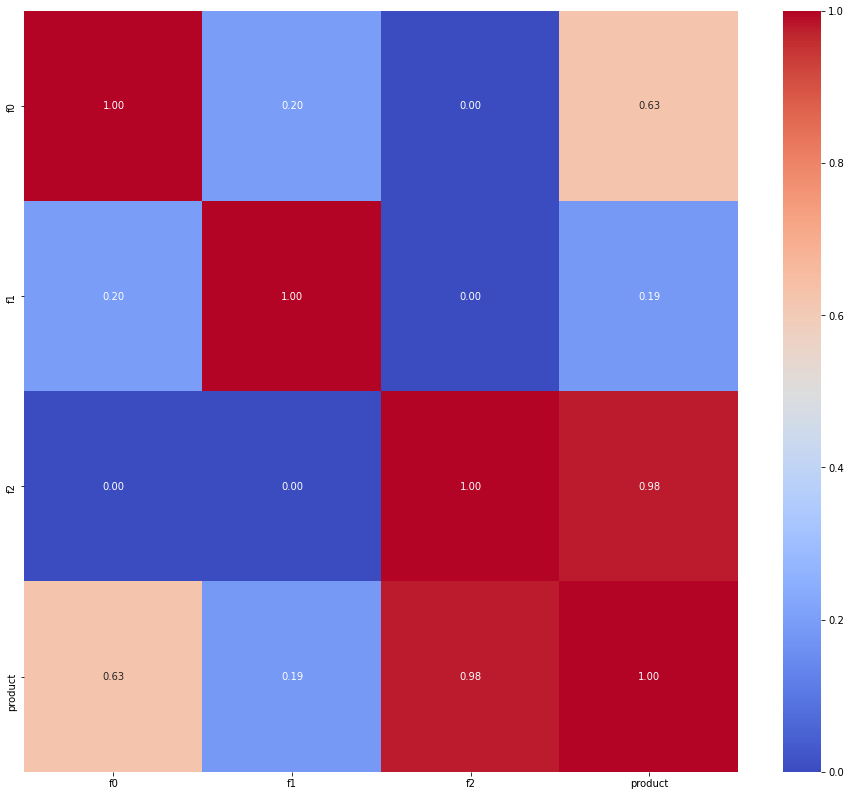

In [34]:
# Матрица корреляций для df_geodata_1
plt.figure(figsize=(16, 14))
sns.heatmap(df_geodata_1.phik_matrix(interval_cols = ['f0', 'f1', 'f2', 'product']), annot=True,  cmap='coolwarm', fmt='.2f');

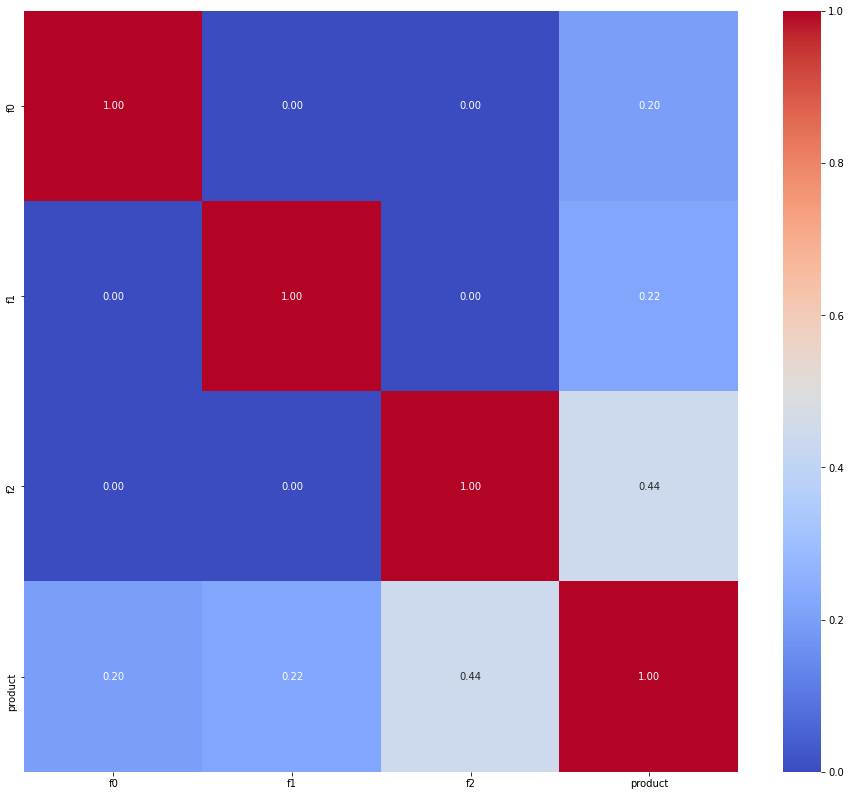

In [35]:
# Матрица корреляций для df_geodata_2
plt.figure(figsize=(16, 14))
sns.heatmap(df_geodata_2.phik_matrix(interval_cols = ['f0', 'f1', 'f2', 'product']), annot=True,  cmap='coolwarm', fmt='.2f');

Судя по тепловой карте и опираясь на шкалу Чеддока мы можем сказать, что:

Для региона 0:
- Есть умеренная связь с целевым признаком `product` у входного признака `f2`
- Среди входных признаков мультиколлинеарности не замечано - отсутствуют коэффициенты корреляции от 0.9 до 0.95 по модулю

Для региона 1:
- Есть высокая связь с целевым признаком `product` у входного признака `f2`
- Есть заметная связь с целевым признаком `product` у входного признака `f0`
- Среди входных признаков мультиколлинеарности не замечано - отсутствуют коэффициенты корреляции от 0.9 до 0.95 по модулю

Для региона 2:
- Есть умеренная связь с целевым признаком `product` у входного признака `f2`
- Среди входных признаков мультиколлинеарности не замечано - отсутствуют коэффициенты корреляции от 0.9 до 0.95 по модулю

На этапе корреляционного анализа данных, нам удалось:
1. Рассчитать и изучить взаимосвязи между всеми признаками


2. Определить тип взаимосвязи между целевыми и входными признаками


3. Проверить входные данные на мультиколлинеарность

## Обучение и проверка модели

### Обучим модель для региона 0

In [36]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
y_valid_pred_mean = []

In [37]:
# Разделение на тренировочную и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    df_geodata_0.drop('product', axis=1),
    df_geodata_0['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

In [38]:
# Вывод необходимых размерностей
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(74992, 3)
(74992,)
(24998, 3)
(24998,)


In [39]:
# Создаём списки с названиями признаков
num_columns = ['f0', 'f1', 'f2']

In [40]:
# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [41]:
# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [42]:
# Обучим модель на тренировочной выборке с помощью пайплайна
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])

In [43]:
# Рассчитаем метрику RMSE и выведите с округлением до второго знака для региона 0
y_valid_pred_0 = pipe_final.predict(X_valid)
y_valid_pred_mean.append(y_valid_pred_0.mean())
print(f'Метрика RMSE на валидационной выборке: {round(sqrt(mean_squared_error(y_valid, y_valid_pred_0)), 2)}')
print(f'Средний запас сырья: {y_valid_pred_mean[0]}')

Метрика RMSE на валидационной выборке: 37.69
Средний запас сырья: 92.60985565185547


In [44]:
df_geodata_0_pred = y_valid
df_geodata_0_pred = pd.DataFrame(df_geodata_0_pred)
df_geodata_0_pred['product_predict'] = y_valid_pred_0

### Обучим модель для региона 1

In [45]:
# Разделение на тренировочную и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    df_geodata_1.drop('product', axis=1),
    df_geodata_1['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

In [46]:
# Вывод необходимых размерностей
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(74997, 3)
(74997,)
(24999, 3)
(24999,)


In [47]:
# Обучим модель на тренировочной выборке с помощью пайплайна
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])

In [48]:
# Рассчитаем метрику RMSE и выведите с округлением до второго знака для региона 1
y_valid_pred_1 = pipe_final.predict(X_valid)
y_valid_pred_mean.append(y_valid_pred_1.mean())
print(f'Метрика RMSE на валидационной выборке: {round(sqrt(mean_squared_error(y_valid, y_valid_pred_1)), 2)}')
print(f'Средний запас сырья: {y_valid_pred_mean[1]}')

Метрика RMSE на валидационной выборке: 0.89
Средний запас сырья: 68.5770263671875


In [49]:
df_geodata_1_pred = y_valid
df_geodata_1_pred = pd.DataFrame(df_geodata_1_pred)
df_geodata_1_pred['product_predict'] = y_valid_pred_1

### Обучим модель для региона 2

In [50]:
# Разделение на тренировочную и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    df_geodata_2.drop('product', axis=1),
    df_geodata_2['product'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

In [51]:
# Вывод необходимых размерностей
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(74997, 3)
(74997,)
(24999, 3)
(24999,)


In [52]:
# Обучим модель на тренировочной выборке с помощью пайплайна
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])

In [53]:
# Рассчитаем метрику RMSE и выведите с округлением до второго знака для региона 2
y_valid_pred_2 = pipe_final.predict(X_valid)
y_valid_pred_mean.append(y_valid_pred_2.mean())
print(f'Метрика RMSE на валидационной выборке: {round(sqrt(mean_squared_error(y_valid, y_valid_pred_2)), 2)}')
print(f'Средний запас сырья: {y_valid_pred_mean[2]} тыс. баррелей')

Метрика RMSE на валидационной выборке: 40.08
Средний запас сырья: 94.93479919433594 тыс. баррелей


In [54]:
df_geodata_2_pred = y_valid
df_geodata_2_pred = pd.DataFrame(df_geodata_2_pred)
df_geodata_2_pred['product_predict'] = y_valid_pred_2

На этапе обучения и проверки модели, нам удалось:
1. Обучить и сделать прогноз для 3-ех разных регионов

## Подготовка к расчёту прибыли

### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [55]:
budg = 10000000000
num_wells = 200
income = 450000
min_value = round(budg / num_wells / income, 2)
print(f'Минимальный объем сырья в скважине для безубыточной разработки: {min_value} тыс. баррелей')

Минимальный объем сырья в скважине для безубыточной разработки: 111.11 тыс. баррелей


### Сравним минимально необходимый объем сырья со средним запасом в каждом регионе

In [56]:
y_valid_pred_mean = pd.DataFrame({'mean':y_valid_pred_mean})
y_valid_pred_mean['region'] = [0, 1 , 2]

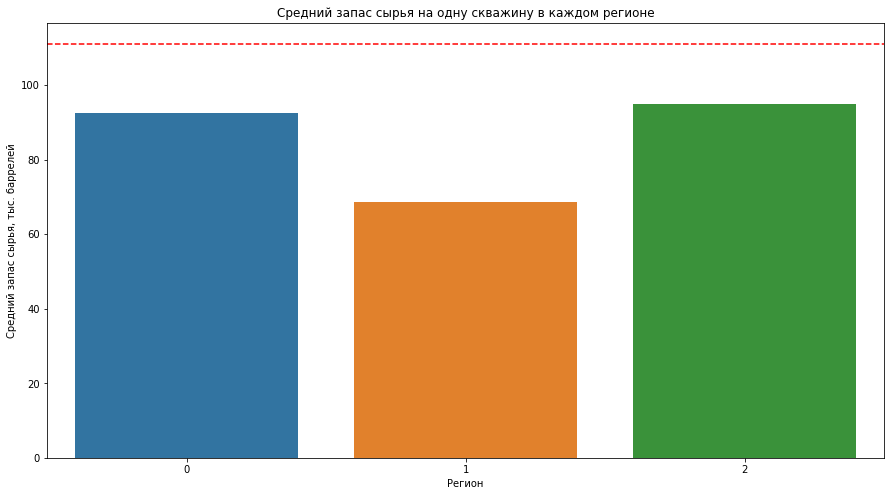

In [57]:
# Построим столбчатый график по средним запасам в каждом регионе
plt.figure(figsize=(15,8))
sns.barplot(data=y_valid_pred_mean, x='region', y='mean')
plt.title('Средний запас сырья на одну скважину в каждом регионе')
plt.xlabel('Регион')
plt.ylabel('Средний запас сырья, тыс. баррелей')
plt.axhline(y=111.11, color='red', linestyle='--');

Как видно из диаграммы - во всех трех регионах средние запасы сырья на одну скважину меньше, чем минимальное необходимое кол-во для достижения безубыточности.

Следовательно, большинство точек в регоинах не подойдут для добычи и отбирать их придется особо тщательно.

На этапе подготовки к расчету прибыли, нам удалось:
1. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины - 111.11 тыс. баррелей


2. Сравнить минимально необходимый объем сырья со средним запасом в каждом регионе -  во всех трех регионах средние запасы сырья на одну скважину меньше, чем минимальное необходимое кол-во для достижения безубыточности

Следовательно, большинство точек в регоинах не подойдут для добычи и отбирать их придется особо тщательно.

## Расчёт прибыли и рисков 

### Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [58]:
state = RandomState(12345) 

In [59]:
def profit(df_pred, df_true):
    values = []
    num_loss = 0
    num_bootstrap = 1000
    num_elem = 500
    for i in range(num_bootstrap):
        subsample = df_pred.sample(num_elem, replace=True, random_state=state)
        subsample = subsample.sort_values(by='product_predict', ascending = False)
        subsample_index = subsample[0:num_wells].index
        values.append(df_true.loc[subsample_index, 'product'].sum()*income - budg)
        if values[i] < 0:
            num_loss += 1
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    print('Средняя выручка:', values.mean())
    print('95%-ый доверительный интервал: (', lower, upper,')')
    print('Риск убытков:', num_loss / num_bootstrap * 100, '%')

### Посчитаем риски и прибыль для каждого региона:

**Для региона 0:**

In [60]:
profit(df_geodata_0_pred, df_geodata_0)

Средняя выручка: 417354308.10546875
95%-ый доверительный интервал: ( -96261967.7734375 933493466.7968748 )
Риск убытков: 5.8999999999999995 %


**Для региона 1:**

In [61]:
profit(df_geodata_1_pred, df_geodata_1)

Средняя выручка: 435440890.0390625
95%-ый доверительный интервал: ( 25316101.074218754 832288400.8789062 )
Риск убытков: 1.9 %


**Для региона 2:**

In [62]:
profit(df_geodata_2_pred, df_geodata_2)

Средняя выручка: 355874640.13671875
95%-ый доверительный интервал: ( -208544702.1484375 869925297.8515625 )
Риск убытков: 9.8 %


На этапе расчета прибыли и рисков, нам удалось:
1. Рассчитать среднюю выручку и риски убытков для 3-ех регионов

2. Найти регион с наибольшей прибылью и наименьшим риском - регион 1

## Общий вывод

**В процессе исследования, мы:**

1. Выгрузили исходные данные в 3 датафрейма

2. Предобработали данные - выставили корректные типы данных, избавились от дубликатов

3. Провели исследовательский анализ данных

По полученным данным, можно сделать несколько выводов:
- медианный объем запасов скважин в регионе 0 - 91 тыс. баррелей
- медианный объем запасов скважин в регионе 1 - 57 тыс. баррелей
- медианный объем запасов скважин в регионе 1 - 94 тыс. баррелей

4. Провели корреляционный анализ данных

Для региона 0:
- Есть умеренная связь с целевым признаком `product` у входного признака `f2`

Для региона 1:
- Есть высокая связь с целевым признаком `product` у входного признака `f2`
- Есть заметная связь с целевым признаком `product` у входного признака `f0`

Для региона 2:
- Есть умеренная связь с целевым признаком `product` у входного признака `f2`

Мультиколлинеарность между входными признаками не наблюдается.

5. Собрали пайплайн, обучили и сделали прогноз для 3-ех разных регионов

5. Рассчитали прибыли и риски для 3-ех регионов

- Регион с наибольшей прибылью и наименьшими рисками - регион 1
- Прибыль от региона 0 - 435 млн. рублей